In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import linalg as LA
import torch.optim as optim
from torchvision import datasets, transforms
from types import SimpleNamespace
import matplotlib.pyplot as plt
import numpy as np

In [101]:
args = SimpleNamespace(batch_size=32, test_batch_size=1000, epochs=10,
                       lr=0.01, momentum=0.5, seed=1, log_interval=100, noise_level=1, beta=0.01)
torch.manual_seed(args.seed)
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [102]:
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                     transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)
    
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)

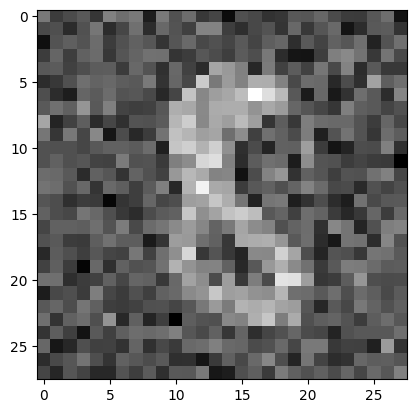

In [103]:
# add some noise to the data
data, train_labels = next(iter(train_loader))
noisy_data = data + args.noise_level * torch.randn(data.shape)
show_img = noisy_data[1][0].numpy()
input_dim = data[1].shape[1] * data[1].shape[2]
plt.imshow(show_img, cmap='gray')
plt.show()

In [104]:
# reshape the data
data = data.view(-1, input_dim)
# and back to the original shape
data = data.view(-1, 1, 28, 28)

In [105]:
class AutoEncoder(nn.Module):
    def __init__(self, size=1600):
        super(AutoEncoder, self).__init__()
        self.linear1 = nn.Linear(input_dim, 256, bias=True)
        self.middle1 = nn.Linear(256, 64, bias=True)
        self.middle2 = nn.Linear(64, 256, bias=True)
        self.linear2 = nn.Linear(256, input_dim, bias=True)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.middle1(x))
        x = F.relu(self.middle2(x))
        x = F.sigmoid(self.linear2(x))
        return x

In [106]:
class SmoothSailing(nn.Module):
    def __init__(self, beta=0):
        super(SmoothSailing, self).__init__()
        self.loss = nn.MSELoss()
        self.beta = beta

    def forward(self, inputs, targets, W1=None, W2=None):
        base_loss = self.loss(inputs, targets)

        if W1 is None or self.beta == 0:
            return base_loss
        else:
            N = max(W1.shape[1], W1.shape[0])
            W1_norm = LA.norm(W1, 2)**2
            W1_fro = LA.norm(W1, 'fro')**2 / N
            W2_norm = LA.norm(W2, 2)**2
            W2_fro = LA.norm(W2, 'fro')**2 / N
            reg_loss = base_loss + self.beta * (W1_norm + W2_norm - W1_fro - W2_fro)
            return base_loss, reg_loss

        

In [107]:
def kappa(W):
    W_max = LA.norm(W, 2)
    W_min = LA.norm(LA.pinv(W), 2)
    return W_max * W_min 

In [108]:
torch.manual_seed(args.seed)
model = AutoEncoder().to(device)
sail = SmoothSailing(beta=0)
optimizer = optim.Adam(model.parameters(), lr=args.lr)

torch.manual_seed(args.seed)
model_reg = AutoEncoder().to(device)
smoothsail = SmoothSailing(beta=args.beta)
optimizer_reg = optim.Adam(model_reg.parameters(), lr=args.lr)
#optim.SGD(model_reg.parameters(), lr=args.lr, momentum=args.momentum)

In [109]:
fit = []
fit_val = []
fit_reg = []
fit_reg_val = []

cond_enc = []
cond_dec = []
cond_enc_reg = []
cond_dec_reg = []

W1 = model.linear1.weight.data
cond_enc.append(kappa(W1))
W2 = model.linear2.weight.data
cond_dec.append(kappa(W2))

W1_reg = model_reg.linear1.weight.data
cond_enc_reg.append(kappa(W1_reg))
W2_reg = model_reg.linear2.weight.data
cond_dec_reg.append(kappa(W2_reg))

print(f"Init condition numbers:")
print(f"\tCondition numbers {cond_enc[-1]:.2f}", f"{cond_dec[-1]:.2f}")
print(f"\tReguarized condition numbers {cond_enc_reg[-1]:.2f}", f"{cond_dec_reg[-1]:.2f}")

# train and evaluate

for epoch in range(args.epochs):
    running_loss = 0.0
    running_loss_reg = 0.0

    running_val_loss = 0.0
    running_val_loss_reg = 0.0

    model.train()
    model_reg.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        noisy_data = data + args.noise_level * torch.randn(data.shape)
        data = Variable(data.view(-1, input_dim))
        target = Variable(noisy_data.view(-1, input_dim))
        data, target = data.to(device), target.to(device)

        output = model(data)
        loss = sail(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output_reg = model_reg(data)
        W1 = model_reg.linear1.weight
        W2 = model_reg.linear2.weight
        loss_bas, loss_reg = smoothsail(output_reg, target, W1, W2)
        optimizer_reg.zero_grad()
        loss_reg.backward()
        optimizer_reg.step()

        running_loss += loss.item()
        running_loss_reg += loss_bas.item()

        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tLoss_reg: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), loss_bas.item()))


    model.eval()
    model_reg.eval()

    with torch.no_grad():
        for data, target in test_loader:
            noisy_data = data + args.noise_level * torch.randn(data.shape)
            data = Variable(data.view(-1, input_dim))
            target = Variable(noisy_data.view(-1, input_dim))
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = sail(output, target)

            output_reg = model_reg(data)
            W1 = model_reg.linear1.weight
            W2 = model_reg.linear2.weight
            loss_bas, loss_reg = smoothsail(output_reg, target, W1, W2)

            running_val_loss += loss.item()
            running_val_loss_reg += loss_bas.item()

    W1 = model.linear1.weight.data
    cond_enc.append(kappa(W1))
    W2 = model.linear2.weight.data
    cond_dec.append(kappa(W2))
    W1_reg = model_reg.linear1.weight.data
    cond_enc_reg.append(kappa(W1_reg))
    W2_reg = model_reg.linear2.weight.data
    cond_dec_reg.append(kappa(W2_reg))

    fit.append(running_loss/len(train_loader.dataset))
    fit_val.append(running_val_loss/args.test_batch_size)
    fit_reg.append(running_loss_reg/len(train_loader.dataset))
    fit_reg_val.append(running_val_loss_reg/args.test_batch_size)


    print(f"Epoch {epoch+1}/{args.epochs}:")
    print(f"\tLoss: {fit[-1]:.2f} with condition numbers {cond_enc[-1]:.2f}", f"{cond_dec[-1]:.2f}")
    print(f"\tRegularized Loss: {fit_reg[-1]:.2f} with condition numbers {cond_enc_reg[-1]:.2f}", f"{cond_dec_reg[-1]:.2f}")

Init condition numbers:
	Condition numbers 3.66 3.60
	Reguarized condition numbers 3.66 3.60
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.219982	Loss_reg: 2.219982
Train Epoch: 0 [3200/60000 (5%)]	Loss: 1.824398	Loss_reg: 1.756163
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.773614	Loss_reg: 1.664950
Train Epoch: 0 [9600/60000 (16%)]	Loss: 1.858838	Loss_reg: 1.716923
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.844741	Loss_reg: 1.660011
Train Epoch: 0 [16000/60000 (27%)]	Loss: 1.808761	Loss_reg: 1.616266
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.869141	Loss_reg: 1.672202
Train Epoch: 0 [22400/60000 (37%)]	Loss: 1.915423	Loss_reg: 1.693981
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.812428	Loss_reg: 1.612835
Train Epoch: 0 [28800/60000 (48%)]	Loss: 1.776334	Loss_reg: 1.556356
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.866406	Loss_reg: 1.655562
Train Epoch: 0 [35200/60000 (59%)]	Loss: 1.843606	Loss_reg: 1.624208
Train Epoch: 0 [38400/60000 (64%)]	Loss: 1.836891	Loss_reg: 1.598767
Train Epoch: 0 [416

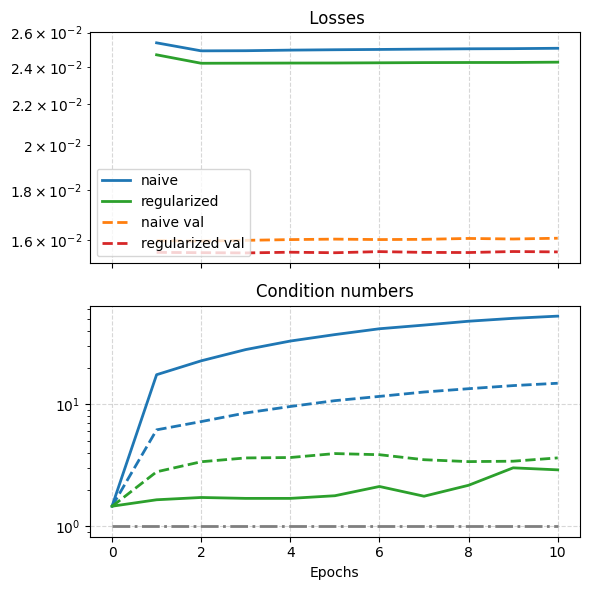

In [86]:
plt.rcParams['text.usetex'] = False

fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
Ts = np.arange(0, args.epochs+1)

ax = axes[0]
ax.plot(Ts[1:], fit, 'tab:blue', linewidth=2, label='naive')
ax.plot(Ts[1:], fit_reg, 'tab:green', linewidth=2, label='regularized')
ax.plot(Ts[1:], fit_val, 'tab:orange', linewidth=2, linestyle='--', label='naive val')
ax.plot(Ts[1:], fit_reg_val, 'tab:red', linewidth=2, linestyle='--', label='regularized val')

ax.set_yscale('log')
ax.set_title(' Losses')
ax.grid(linestyle='--', alpha=0.5)

ax = axes[1]
ax.plot(Ts, cond_enc, 'tab:blue', linewidth=2)
ax.plot(Ts, cond_dec, 'tab:blue', linewidth=2, linestyle='--')
ax.plot(Ts, cond_enc_reg, 'tab:green', linewidth=2)
ax.plot(Ts, cond_dec_reg, 'tab:green', linewidth=2, linestyle='--')
ax.plot(Ts, np.ones(len(Ts)), 'tab:gray', linewidth=2, label='Tightened', linestyle='-.')
ax.set_yscale('log')

ax.set_title('Condition numbers')
ax.set_xlabel('Epochs')
axes[0].legend(loc='lower left')
ax.grid(linestyle='--', alpha=0.5)

plt.tight_layout()

plt.savefig('Fit_MNIST.pdf', bbox_inches='tight')